In [1]:
from lsst.daf.butler import Butler
import lsst.analysis.drp
import itertools

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
butler_deep = Butler(config="s3://butler-us-central1-panda-dev/dc2/butler-external.yaml", 
                     collections="2.2i/runs/test-tract4431/v23_0_0_rc2/PREOPS-728")

Plotting all visit-detector pairs
====

In [3]:
%%time

calexp_datasets = set(butler_deep.registry.queryDatasets("calexp"))
len(calexp_datasets)

CPU times: user 1.18 s, sys: 29.5 ms, total: 1.21 s
Wall time: 1.35 s


30495

In [4]:
calexp_dataIds = set(x.dataId for x in calexp_datasets)

In [5]:
visits = set(x.dataId['visit'] for x in calexp_datasets)
len(visits)

1186

In [6]:
# I want to plot all the visits consecutively,rather than being spaced out according to their visit number.

visit_substitution_dict = {}
for n, visit in enumerate(visits):
    visit_substitution_dict[visit] = n

In [7]:
dataRef_list = list(calexp_datasets)
visit_plot_values = np.array([visit_substitution_dict[x.dataId['visit']] for x in dataRef_list])
detector_plot_values = np.array([x.dataId['detector'] for x in dataRef_list])

In [8]:
matplotlib.rcParams['figure.dpi'] = 200

Text(0.5, 0, 'Detector number')

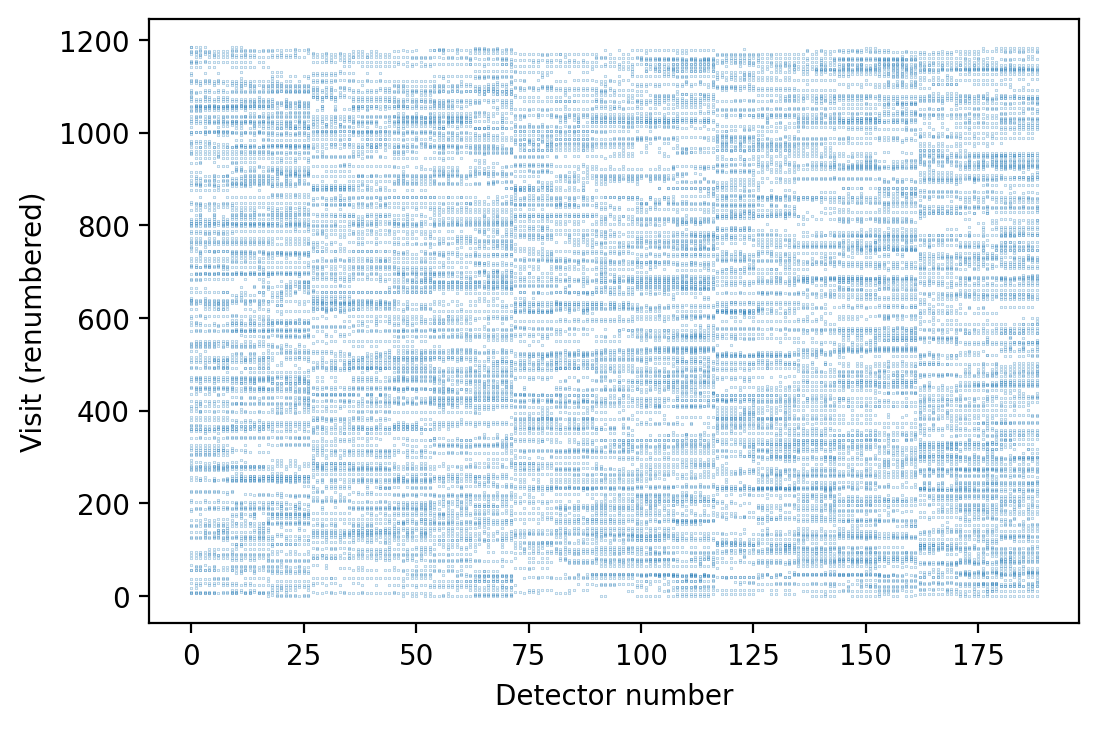

In [9]:
plt.plot(detector_plot_values, visit_plot_values, '.', ms=0.2)
plt.ylabel("Visit (renumbered)")
plt.xlabel("Detector number")

**Conclusion**: Since step1 in the pilot run selected on `tract in (4431)`, only detectors matching that selection were processed, instead of full visits. So any analysis will have be careful about what data should exist, and not just expect all of data in the overlapping visits.

Finding missing calexps
====

We want to find any visit-ccd pairs that should have been processed, but don't have a calexp in the output repo.

In [10]:
%%time

# This where clause is the same as the dataQuery used in step1 of the processing.
raws_4431_dataIds = set(butler_deep.registry.queryDataIds(("visit", "detector"), 
                        where="instrument='LSSTCam-imSim' and skymap='DC2' and tract in (4431)"))

CPU times: user 2.55 s, sys: 106 ms, total: 2.66 s
Wall time: 4.94 s


In [11]:
len(raws_4431_dataIds)

30535

In [12]:
# raws_4431_dataIds and calexp_dataIds are both sets, so subtracting them gives any raws that don't have calexps.
missing_calexp_dataIds = list(raws_4431_dataIds - calexp_dataIds)
print(len(missing_calexp_dataIds))

40


In [13]:
missing_calexp_dataIds

[{instrument: 'LSSTCam-imSim', detector: 186, visit: 191144, ...},
 {instrument: 'LSSTCam-imSim', detector: 188, visit: 191144, ...},
 {instrument: 'LSSTCam-imSim', detector: 85, visit: 699456, ...},
 {instrument: 'LSSTCam-imSim', detector: 87, visit: 699456, ...},
 {instrument: 'LSSTCam-imSim', detector: 142, visit: 699456, ...},
 {instrument: 'LSSTCam-imSim', detector: 122, visit: 699456, ...},
 {instrument: 'LSSTCam-imSim', detector: 183, visit: 199534, ...},
 {instrument: 'LSSTCam-imSim', detector: 31, visit: 699457, ...},
 {instrument: 'LSSTCam-imSim', detector: 183, visit: 191144, ...},
 {instrument: 'LSSTCam-imSim', detector: 114, visit: 250396, ...},
 {instrument: 'LSSTCam-imSim', detector: 144, visit: 699456, ...},
 {instrument: 'LSSTCam-imSim', detector: 80, visit: 699456, ...},
 {instrument: 'LSSTCam-imSim', detector: 93, visit: 692613, ...},
 {instrument: 'LSSTCam-imSim', detector: 185, visit: 199534, ...},
 {instrument: 'LSSTCam-imSim', detector: 188, visit: 199534, ...},


Categorizing error messages
----

There were two types of failures identified by the processing team in PREOPS-728. One is:
> Unable to measure aperture correction for required algorithm 'modelfit_CModel': only 0 sources, but require at least

and another is

> Fit failed: median scatter on sky = 11.317 arcsec > 10.000 config.maxScatterArcsec

The loop below will search through all the error messages in the logs of the "missing" calexps, and if the message contains the string in the `cause_dict` key, will store the dataId and log message in a list in `cause_dict`. 

"missing" calexps that don't match any of the `cause_dict` keys will be stored in `cause_uncategorized`. If there are no log datasets available to search, the dataId will be stored in `no_logs`.

This currently searches for error causes in `exc_info`, but after DM-32504 the exception text will appear in the log message itself.

In [15]:

cause_dict = {"median scatter": [],
              "aperture correction": []}

cause_uncategorized = []

no_logs = []

loglevel = 40 # Error

for dataId in missing_calexp_dataIds:
    log_datasets = list(filter(lambda x: 'detector' in x.dimensions, butler_deep.registry.queryDatasets('*log', dataId=dataId)))    

    if(len(log_datasets) == 0):
        no_logs.append(dataId)
        print("No logs for dataId ", dataId)
        continue

    categorized = False        
    for log_dataset in log_datasets:
        log_file = butler_deep.getDirect(log_dataset)
        for log_line in log_file:

            if(log_line.levelno >= loglevel):

                for cause_string in cause_dict.keys():
                    if(cause_string in log_line.exc_info):
                        categorized = True
                        cause_dict[cause_string].append((log_dataset.dataId, log_line))

    if(not categorized):
        cause_uncategorized.append(log_dataset.dataId)

No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 186, visit: 191144, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 188, visit: 191144, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 183, visit: 199534, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 183, visit: 191144, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 185, visit: 199534, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 188, visit: 199534, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 172, visit: 181900, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 187, visit: 199534, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 185, visit: 191144, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 187, visit: 191144, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 171, visit: 181900, ...}
No logs for dataId  {instrument: 'LSSTCam-imSim', detector: 182, 

In [16]:
print("Cause               | n_calexps")
print("-"*40)
print("Median scatter      | {:d}".format(len(cause_dict["median scatter"])))
print("aperture correction | {:d}".format(len(cause_dict["aperture correction"])))
print("Uncategorized       | {:d}".format(len(cause_uncategorized)))
print("No Logs             | {:d}".format(len(no_logs)))

Cause               | n_calexps
----------------------------------------
Median scatter      | 5
aperture correction | 20
Uncategorized       | 0
No Logs             | 15


In [17]:
success = 0
fail = 0
for dataId in no_logs:
    
    # Have to look up the exposure number before we can call butler.get() on the dataId
    exposure_dataIds = list(butler_deep.registry.queryDataIds(("visit", "exposure", "detector"), dataId=dataId))
    exposure_dataId = exposure_dataIds[0]
    try:
        raw = butler_deep.get("raw", dataId=dataId)
        success += 1
    except LookupError:
        fail += 1
        
    
print("Raw access success: {:d}, fail: {:d}".format(success, fail))

Raw access success: 0, fail: 15


**Conclusion**: All of the missing calexps are either due to known issues, or the original raws are also missing. 